# Submit transpiled circuits

[Link](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits)

## Background

To get the best performance from your circuits, the Qiskit Runtime service will pass all circuits through Qiskit's transpiler before running them. While this is usually a good thing, we might sometimes want to disable this by passing the argument skip_transpilation=True to the primitive we're using.

For example, we may know better than the transpiler in some cases, or want to target a specific subset of qubits on a specific device. In this tutorial, we'll disable automatic transpilation to test the performance of different transpiler settings. This example will take you through the full process of creating, transpiling, and submitting circuits.



In [1]:
# General
import warnings
warnings.filterwarnings("ignore")

# Create circuit to test transpiler on
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

In [3]:
pass
# %pip install pylatexenc

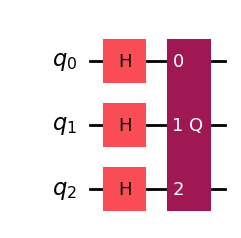

In [4]:
oracle = Diagonal([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0, 1, 2])
qc = qc.compose(GroverOperator(oracle))

qc.draw(output="mpl", style="iqp")

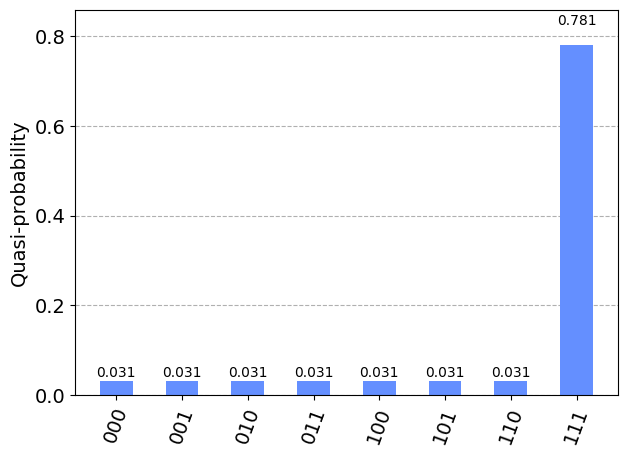

In [5]:

ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

In [6]:
# Need to add measurements to the circuit
qc.measure_all()

circuits = []
for optimization_level in [0, 3]:
    t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
    print(f"ECRs (optimization_level={optimization_level}): ", t_qc.count_ops()["ecr"])
    circuits.append(t_qc)

ECRs (optimization_level=0):  27
ECRs (optimization_level=3):  14


In [7]:
from qiskit.transpiler import PassManager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

# Get gate durations so the transpiler knows how long each operation takes
durations = backend.target.durations()

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm = PassManager([ASAPScheduleAnalysis(durations), PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circuits[1])

# Add this new circuit to our list
circuits.append(circ_dd)

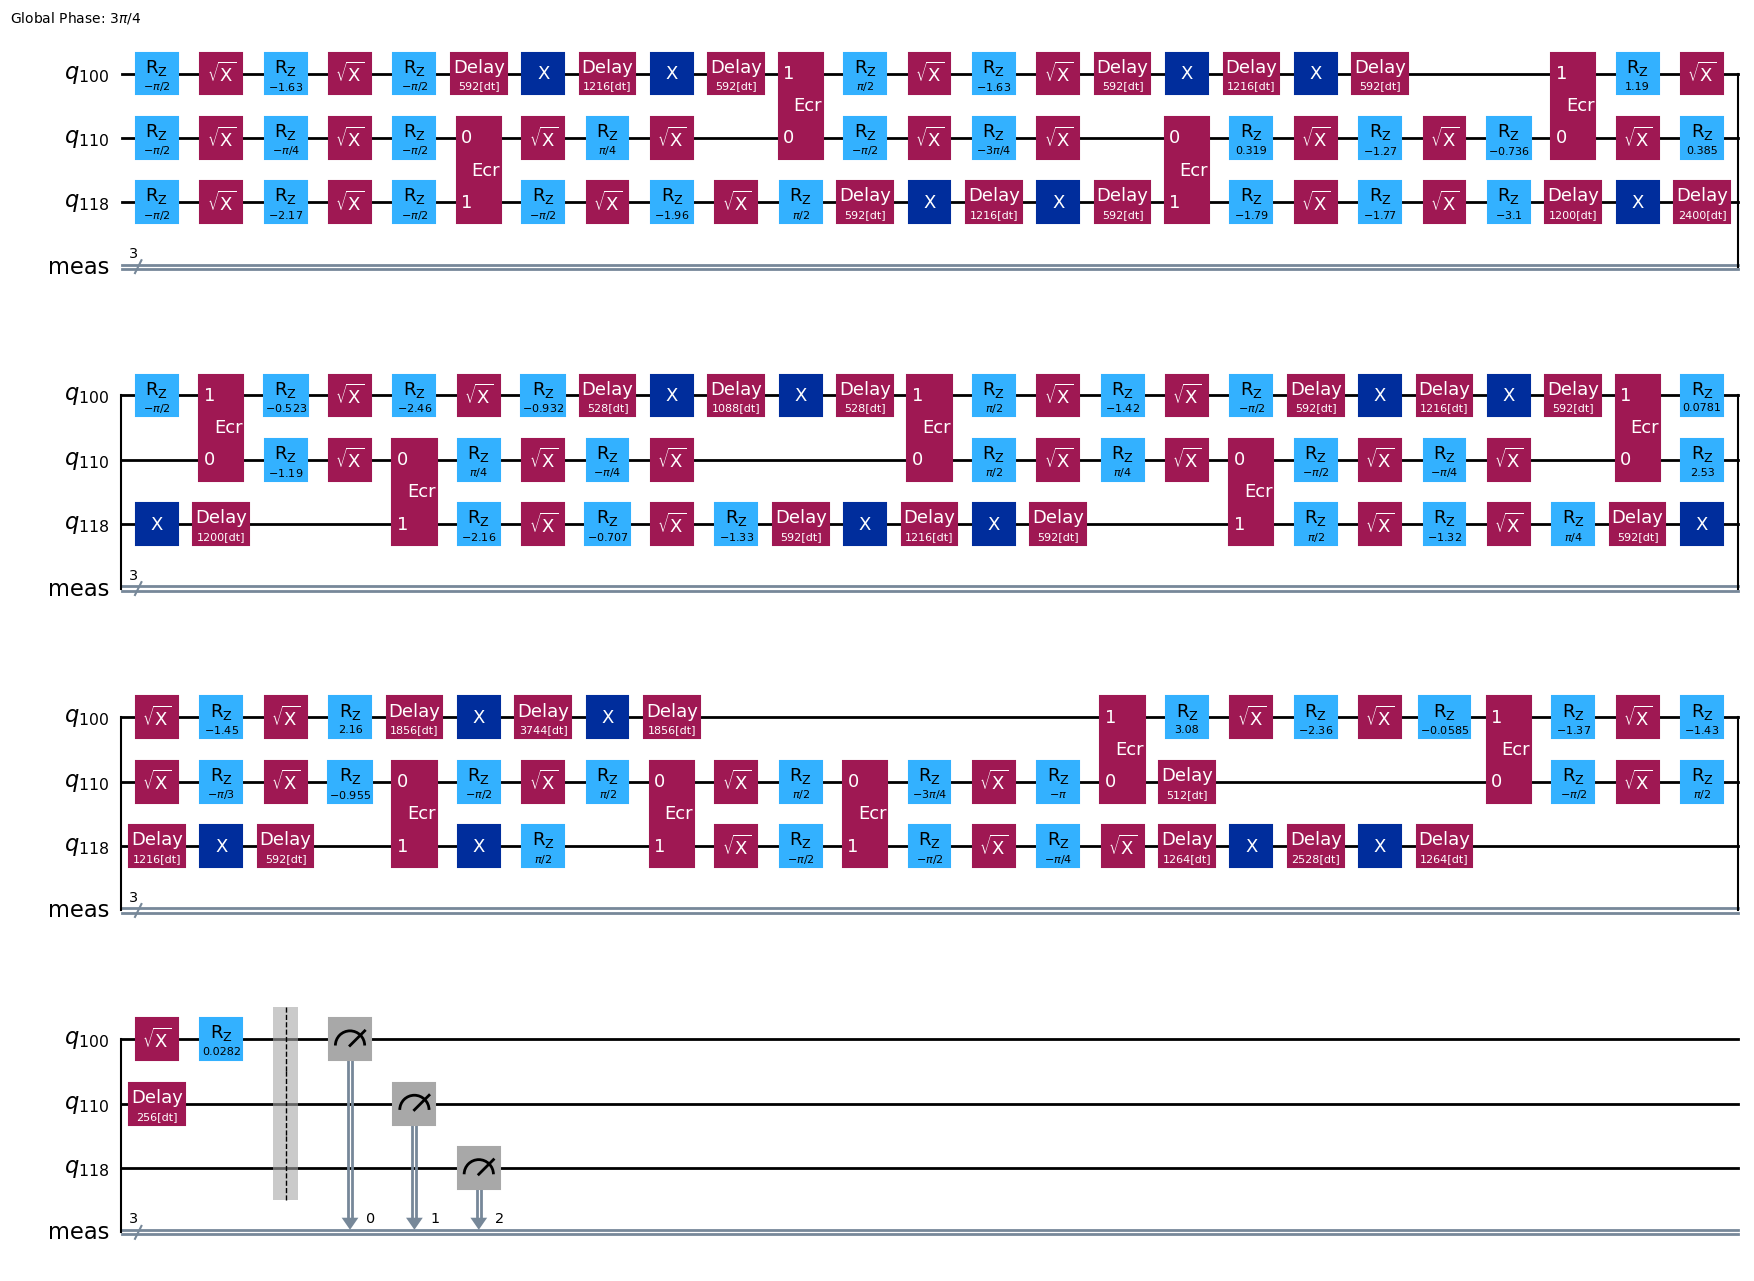

In [8]:
circ_dd.draw(output="mpl", style="iqp", idle_wires=False)

In [9]:
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=circuits,  # sample all three circuits
        skip_transpilation=True,
        shots=8000,
    )
    result = job.result()

In [ ]:
binary_prob = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
plot_histogram(
    binary_prob + [ideal_distribution],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "optimization_level=3 + dd",
        "ideal distribution",
    ],
)